In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
def getMoves(board):
    moves = []
    for i in range(len(board)):
        for j in range(len(board[i])):
            if board[i][j] == 0:
                moves.append((i, j))
    return moves

def check_win(arr, len_board):
    if len_board == 3:
        if arr[0] == arr[1] == arr[2] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == 2:
            return 2
        else:
            return False
    elif len_board == 5:
        if len(arr) == 4:
            if arr[0] == arr[1] == arr[2] == arr[3] == 1:
                return 1
            elif arr[0] == arr[1] == arr[2] == arr[3] == 2:
                return 2
            else:
                return False
        else:
            if arr[0] == arr[1] == arr[2] == arr[3] == 1:
                return 1
            elif arr[1] == arr[2] == arr[3] == arr[4] == 1:
                return 1
            elif arr[0] == arr[1] == arr[2] == arr[3] == 2:
                return 2
            elif arr[1] == arr[2] == arr[3] == arr[4] == 2:
                return 2
            else:
                return False


"""
This function checks the board state to find a winner and works with the check_win function in sync.
Inputs: board - current board state (list of lists)
Outputs: 
"""


def getWinner(board):
    # represent the board as an array for easier manipulation
    board_array = np.array(board)
    wins = []

    # iterate through columns to check for vertical wins
    for j in range(len(board)):
        # slice each column, check for win
        winner = check_win(board_array[:, j], len_board=len(board))
        wins.append(winner)

    # iterate through rows to check for horizontal wins
    for i in range(len(board)):
        # slice each row, check for win
        winner = check_win(board_array[i, :], len_board=len(board))
        wins.append(winner)

    # get diagonals of board
    # note: this approach identifies ALL diagonals in the board (not only those of length 3), handled later
    diags = [board_array[::-1, :].diagonal(i)
             for i in range(-board_array.shape[0] + 1, board_array.shape[1])]
    diags.extend(board_array.diagonal(i) for i in range(
        board_array.shape[1] - 1, -board_array.shape[0], -1))

    # only the main diagonal and anti diagonal can be used for a win, so check for win only in those
    for each in diags:
        if len(board) == 3 and len(each) == 3:
            wins.append(check_win(each, len_board=len(board)))

        if len(board) == 5 and len(each) >= 4:
            wins.append(check_win(each, len_board=len(board)))

    # remove all booleans, leaving only integer values (1 or 2) to indicate a winner
    wins2 = [win for win in wins if win]

    # if there is no integer in wins2 (no winner yet) and if there are no more valid moves, it's a tie (return 0)
    if not wins2:
        if len(getMoves(board)) == 0:
            return 0

    # if there is an integer in wins2, there is a winner. return the winner, else, there are still moves to be made (return -1)
    if wins2:
        return wins2[0]
    else:
        return -1

In [3]:
def parse_filename(filename):
    board_size = filename[0]
    parsed = filename.split("_")
    p1 = parsed[1]
    p2 = parsed[2]

    if "dnn" in p1:
        p1_model = "dnn"
    elif "minimax" in p1:
        p1_model = "minimax"

    if "dnn" in p2:
        p2_model = "dnn"
    elif "minimax" in p2:
        p2_model = "minimax"
        
    p1_model_level = int(p1[-1])
    p2_model_level = int(p2[-1])
        
    #return [filename, p1_model, p1_model_level, p2_model, p2_model_level]
    return [board_size, p1_model, p1_model_level, p2_model, p2_model_level]

In [4]:
def data_per_game(filename):
    df = pd.read_csv(filename, header=None)
    df.columns = ["Previous State", "Next State", "Player", "Cyber Move", "Game ID"]
    
    if "/" in filename:
        board_size, p1_model, p1_model_level, p2_model, p2_model_level = parse_filename(filename.split("/")[-1])
    else:
        board_size, p1_model, p1_model_level, p2_model, p2_model_level = parse_filename(filename)
    
    data_dict = {}
    
    for each in np.unique(df["Game ID"]):
        
        frame = df[df["Game ID"] == each]
        moves = frame["Next State"].to_list()
        last_state = ast.literal_eval(moves[-1])
        winner = getWinner(last_state)
    
        data_dict[each] = [len(np.unique(df["Game ID"])), board_size, winner, p1_model, p1_model_level, p2_model, p2_model_level]
        #data_dict[each] = [len(np.unique(df["Game ID"])), board_size, winner, p1_moves, p1_model, p1_model_level, p2_moves, p2_model, p2_model_level, total_nmoves]
        
    return data_dict

In [5]:
def generate_map(filepath, player=1, model1="minimax", model2="minimax", ties=False):

    all_data = []
    
    for file in os.listdir(filepath):
        if file.endswith(".csv"):
            
            if file[-1] == "/":
                data = data_per_game(filename=f"{filepath}{file}")
            else:
                data = data_per_game(filename=f"{filepath}/{file}")
                
            all_data.append(data)
    
    arr = np.ndarray(shape=(6,6))
    arr.fill(0)
    
    for each in all_data:
        for key in each:
            ngames, board_size, winner, p1_model, p1_model_level, p2_model, p2_model_level = each[key]
            
            if not ties:
                if p1_model == p2_model == model1 == model2:
                    if winner == player:
                        arr[p1_model_level][p2_model_level] += 1

                elif p1_model == model1 and p2_model == model2:
                    if winner == player:
                        arr[p1_model_level][p2_model_level] += 1
            else:
                if p1_model == p2_model == model1 == model2:
                    if winner == 0:
                        arr[p1_model_level][p2_model_level] += 1
                elif p1_model == model1 and p2_model == model2:
                    if winner == 0:
                        arr[p1_model_level][p2_model_level] += 1
                    
    color = "Blues"
    ax = plt.axes()
    
    if not ties:
        ax.set_title(f"Games Won By Player {player}")
    if ties:
        ax.set_title(f"Number of Tie Games")
    ax = sns.heatmap(arr, annot=True, fmt=".3g", ax = ax, cmap=color)
    plt.xlabel(f"Defender Skill Level ({model2})")
    plt.ylabel(f"Attacker Skill Level ({model1})")
    plt.show()
    return arr

In [6]:
def game_stats(filepath, player=1):
    stats = {"win" : 0, "loss" : 0, "draw" : 0, "total" : 0, "board_length" : 0}
    info = {}
    
    for file in os.listdir(filepath):
        if file.endswith(".csv"):
            
            if file[-1] == "/":
                dfpath = f"{filepath}{file}"
            else:
                dfpath = f"{filepath}/{file}"
            
            df = pd.read_csv(dfpath, header=None)
            df.columns = ["Previous State", "Next State", "Player", "Cyber Move", "Game ID"]
            
            for each in np.unique(df["Game ID"]):
                
                game = df[df["Game ID"] == each]
                game.reset_index(drop=True, inplace=True)
            
                last_state = ast.literal_eval(game["Next State"].to_list()[-1])
                winner = getWinner(last_state)
                       
                info[each] = winner

                stats["total"] += 1
                stats["board_length"] = len(last_state)

                if winner == player:
                    stats["win"] += 1
                elif winner == 0:
                    stats["draw"] += 1
                
    stats["loss"] = stats["total"] - stats["win"] - stats["draw"]
    
    return stats, info

In [7]:
def win_pct(arr, board, d=False):
    
    if not d:
        if board == 3:
            total = 360
        elif board == 5:
            total = 180

        return round(100*np.sum(arr)/total, 3)
    
    if d:
        if board == 3:
            total = 60
        elif board == 5:
            total = 30
            
        diag = np.diagonal(arr)
        return round(100*np.sum(diag)/total, 3)

# 3x3 tic-tac-toe

In [8]:
filepath = "./3x3_experiments/gameplay_3x3_experiments"

In [9]:
stats, info = game_stats(filepath=filepath)
stats

{'win': 663, 'loss': 711, 'draw': 66, 'total': 1440, 'board_length': 3}

In [10]:
data = {}

## DNN vs. DNN

In [11]:
model1, model2 = "dnn", "dnn"

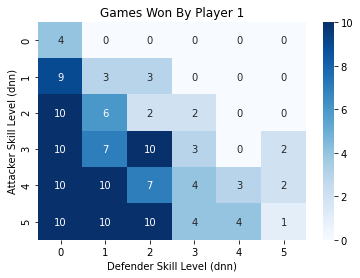

In [12]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

Consider the main diagonal of the heatmap, where the attacker and defender skill levels are equivalent. Player 1 wins a maximum of 40% of the games in each experiment.

The bulk of Player 1 wins come from a high-skilled attacker vs. a low-skilled defender.

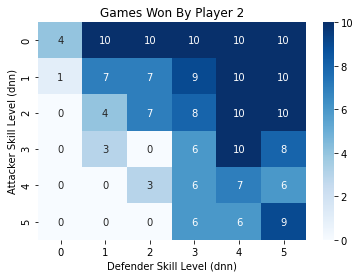

In [13]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

Consider the main diagonal once more. Player 2 defends very well against Player 1 at the same skill level, winning the majority of games per experiment where the skill levels are equivalent.

Player 2 performs best as a high-skilled defender vs. a low-skilled attacker.

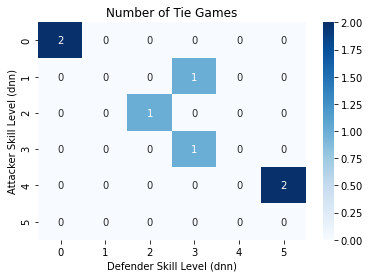

In [14]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

There are relatively few tie games for DNN vs. DNN, but the tie games occur when the attacker and defender skill levels are equivalent or somewhat close to one another.

In [15]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=3), win_pct(arr2, board=3), win_pct(arr3, board=3),
                                 win_pct(arr1, board=3, d=True), win_pct(arr2, board=3, d=True), win_pct(arr3, board=3, d=True)]

## DNN vs. Minimax

In [16]:
model1, model2 = "dnn", "minimax"

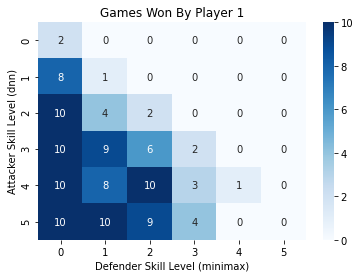

In [17]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

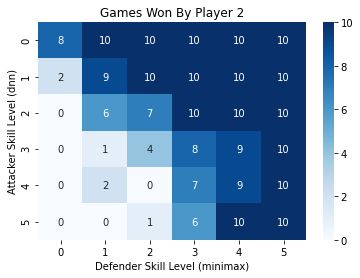

In [18]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

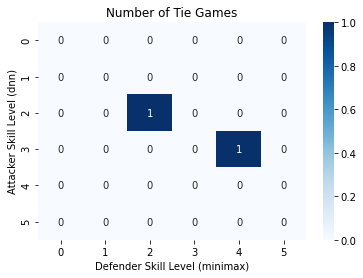

In [19]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [20]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=3), win_pct(arr2, board=3), win_pct(arr3, board=3),
                                 win_pct(arr1, board=3, d=True), win_pct(arr2, board=3, d=True), win_pct(arr3, board=3, d=True)]

## Minimax vs. DNN

In [21]:
model1, model2 = "minimax", "dnn"

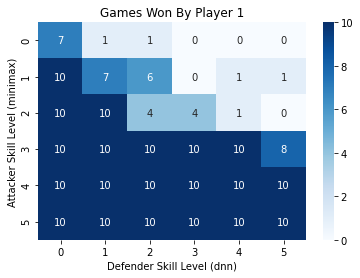

In [22]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

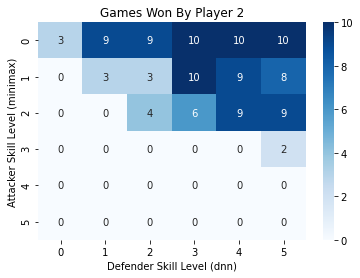

In [23]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

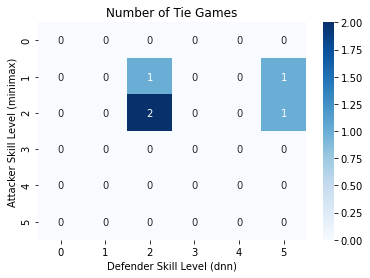

In [24]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [25]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=3), win_pct(arr2, board=3), win_pct(arr3, board=3),
                                 win_pct(arr1, board=3, d=True), win_pct(arr2, board=3, d=True), win_pct(arr3, board=3, d=True)]

## Minimax vs. Minimax

In [26]:
model1, model2 = "minimax", "minimax"

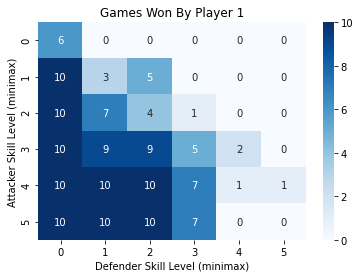

In [27]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

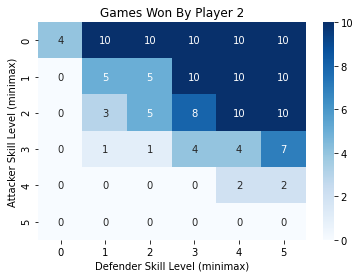

In [28]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

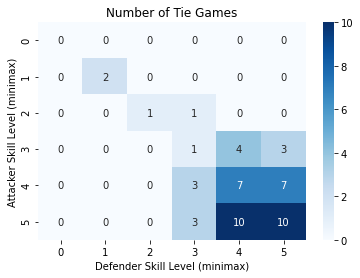

In [29]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [30]:
np.sum(arr3)

52.0

In [31]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=3), win_pct(arr2, board=3), win_pct(arr3, board=3),
                                 win_pct(arr1, board=3, d=True), win_pct(arr2, board=3, d=True), win_pct(arr3, board=3, d=True)]

## 3x3 W/L/D Data

In [32]:
# key = models
# values = [% won by p1, % won by p2, % of ties, % won by p1 @ same skill level, % won by p2 @ same skill level, % tied @ same skill level]
data

{'dnn vs dnn': [40.556, 57.5, 1.944, 26.667, 66.667, 6.667],
 'dnn vs minimax': [33.056, 66.389, 0.556, 13.333, 85.0, 1.667],
 'minimax vs dnn': [66.944, 31.667, 1.389, 80.0, 16.667, 3.333],
 'minimax vs minimax': [43.611, 41.944, 14.444, 31.667, 33.333, 35.0]}

# 5x5 tic-tac-toe

In [ ]:
data = {}

In [ ]:
filepath = "./5x5_experiments/gameplay_5x5_experiments"

In [ ]:
stats, info = game_stats(filepath=filepath)
stats

## DNN vs. DNN

In [ ]:
model1, model2 = "dnn", "dnn"

In [ ]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

In [ ]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

In [ ]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [ ]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=5), win_pct(arr2, board=5), win_pct(arr3, board=5),
                                 win_pct(arr1, board=5, d=True), win_pct(arr2, board=5, d=True), win_pct(arr3, board=5, d=True)]

## DNN vs. Minimax

In [ ]:
model1, model2 = "dnn", "minimax"

In [ ]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

In [ ]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

In [ ]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [ ]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=5), win_pct(arr2, board=5), win_pct(arr3, board=5),
                                 win_pct(arr1, board=5, d=True), win_pct(arr2, board=5, d=True), win_pct(arr3, board=5, d=True)]

## Minimax vs. DNN

In [ ]:
model1, model2 = "minimax", "dnn"

In [ ]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

In [ ]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

In [ ]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [ ]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=5), win_pct(arr2, board=5), win_pct(arr3, board=5),
                                 win_pct(arr1, board=5, d=True), win_pct(arr2, board=5, d=True), win_pct(arr3, board=5, d=True)]

## Minimax vs. Minimax

In [ ]:
model1, model2 = "minimax", "minimax"

In [ ]:
arr1 = generate_map(filepath=filepath, model1=model1, model2=model2, player=1)

In [ ]:
arr2 = generate_map(filepath=filepath, model1=model1, model2=model2, player=2)

In [ ]:
arr3 = generate_map(filepath=filepath, model1=model1, model2=model2, ties=True)

In [ ]:
data[f"{model1} vs {model2}"] = [win_pct(arr1, board=5), win_pct(arr2, board=5), win_pct(arr3, board=5),
                                 win_pct(arr1, board=5, d=True), win_pct(arr2, board=5, d=True), win_pct(arr3, board=5, d=True)]

## 5x5 W/L/D Data

In [ ]:
# key = models
# values = [% won by p1, % won by p2, % of ties]
data